<a href="https://colab.research.google.com/github/jdiazram/lecturasIIC3633-2021/blob/main/practicos/Implicit_implicit_feedback_JDR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Práctico librería implicit - ALS y BPR

Clase: IIC3633 Sistemas Recomendadores, PUC Chile

En este práctico vamos a utilizar la biblioteca de Python [implicit](https://implicit.readthedocs.io/en/latest/quickstart.html) para recomendación utilizando ALS y BPR. 


In [1]:
!curl -L -o "u2.base" "https://drive.google.com/uc?export=download&id=1bGweNw7NbOHoJz11v6ld7ymLR8MLvBsA"
!curl -L -o "u2.test" "https://drive.google.com/uc?export=download&id=1f_HwJWC_1HFzgAjKAWKwkuxgjkhkXrVg"
!curl -L -o "u.item" "https://drive.google.com/uc?export=download&id=10YLhxkO2-M_flQtyo9OYV4nT9IvSESuz"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0    270      0 --:--:--  0:00:01 --:--:--   270
100 1546k  100 1546k    0     0   854k      0  0:00:01  0:00:01 --:--:-- 9489k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0    468      0 --:--:-- --:--:-- --:--:--   468
100  385k  100  385k    0     0   330k      0  0:00:01  0:00:01 --:--:--  330k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0    562      0 --:--:-- --:--:-- --:--:--   562
100  230k  100  230k    0     0   211k      0  0:00:01  0:00:01 --:--:--  211k


In [2]:
!pip3 install implicit --upgrade

     |████████████████████████████████| 1.1 MB 16.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for implicit: filename=implicit-0.4.8-cp37-cp37m-linux_x86_64.whl size=4606570 sha256=9b33abdef1c030d8741a5d1f8be4ac8d3161c2bb977f6d2b3720f33a431d6287
  Stored in directory: /root/.cache/pip/wheels/88/e6/34/25e73cccbaf1a961154bb562a5f86123b68fdbf40e306073d6
Successfully built implicit


In [24]:
import pandas as pd
import numpy as np
import implicit
import scipy.sparse as sparse
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
columns = ['movieid', 'title', 'release_date', 'video_release_date', \
           'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', \
           'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', \
           'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', \
           'Thriller', 'War', 'Western']

In [5]:
# Primero creamos el dataframe con los datos
df_train = pd.read_csv('u2.base',
                         sep='\t',
                         names=['userid', 'itemid', 'rating', 'timestamp'],
                         header=None)

# rating >= 3 , relevante (1) y rating menor a 3 es no relevante (0)
df_train.rating = [1 if x >=3 else 0 for x in df_train.rating ]

In [6]:
df_train.head()

,userid,itemid,rating,timestamp
0,1,3,1,878542960
1,1,4,1,876893119
2,1,5,1,889751712
3,1,6,1,887431973
4,1,7,1,875071561


In [7]:
# Cargamos el dataset con los items
df_items = pd.read_csv('u.item',
                        sep='|',
                        index_col=0,
                        names = columns,
                        header=None, 
                        encoding='latin-1')

In [8]:
df_items.head()

,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [9]:
# Cargamos el dataset de testing
df_test = pd.read_csv('u2.test',
                      sep='\t',
                      names=['userid', 'itemid', 'rating', 'timestamp'],
                      header=None)


# rating >= 3 es relevante (1) y rating menor a 3 es no relevante (0) 
df_test.rating = [1 if x >=3 else 0 for x in df_test.rating ]


user_items_test = {}

for row in df_test.itertuples():
    if row[1] not in user_items_test:
        user_items_test[row[1]] = []
        
    user_items_test[row[1]].append(row[2])

In [10]:
df_test.head()

,userid,itemid,rating,timestamp
0,1,1,1,874965758
1,1,2,1,876893171
2,1,8,0,875072484
3,1,9,1,878543541
4,1,21,0,878542772


### Métricas

In [11]:
# Definicion de métricas (No editar)
# Obtenido de https://gist.github.com/bwhite/3726239

def precision_at_k(r, k):
    assert k >= 1
    r = np.asarray(r)[:k] != 0
    if r.size != k:
        raise ValueError('Relevance score length < k')
    return np.mean(r)

def average_precision(r):
    r = np.asarray(r) != 0
    out = [precision_at_k(r, k + 1) for k in range(r.size) if r[k]]
    if not out:
        return 0.
    return np.mean(out)

def mean_average_precision(rs):
    return np.mean([average_precision(r) for r in rs])
  
def dcg_at_k(r, k):
    r = np.asfarray(r)[:k]
    if r.size:
        return np.sum(np.subtract(np.power(2, r), 1) / np.log2(np.arange(2, r.size + 2)))
    return 0.


def ndcg_at_k(r, k):
    idcg = dcg_at_k(sorted(r, reverse=True), k)

    if not idcg:
        return 0.
    return dcg_at_k(r, k) / idcg

### Preprocesamiento de los datos a formato sparse

In [12]:
user_items = {}
itemset = set()

for row in df_train.itertuples():
    if row[1] not in user_items:
        user_items[row[1]] = []
        
    user_items[row[1]].append(row[2])
    itemset.add(row[2])

itemset = np.sort(list(itemset))

sparse_matrix = np.zeros((len(user_items), len(itemset)))

for i, items in enumerate(user_items.values()):
    sparse_matrix[i] = np.isin(itemset, items, assume_unique=True).astype(int)
    
matrix = sparse.csr_matrix(sparse_matrix.T)

user_ids = {key: i for i, key in enumerate(user_items.keys())}
user_item_matrix = matrix.T.tocsr()

In [13]:
def evaluate_model(model, n):
  mean_map = 0.
  mean_ndcg = 0.
  for u in user_items_test.keys():
    rec = [t[0] for t in model.recommend(u, user_item_matrix, n)]
    rel_vector = [np.isin(user_items_test[u], rec, assume_unique=True).astype(int)]
    mean_map += mean_average_precision(rel_vector)
    mean_ndcg += ndcg_at_k(rel_vector, n)

  mean_map /= len(user_items_test)
  mean_ndcg /= len(user_items_test)
  
  return mean_map, mean_ndcg

In [14]:
def show_recommendations(model, user, n):
  recommendations = [t[0] for t in model.recommend(user, user_item_matrix, n)]
  return df_items.loc[recommendations]['title']

In [15]:
def show_similar_movies(model, item, n=10):
  sim_items = [t[0] for t in model.similar_items(item, n)]
  return df_items.loc[sim_items]['title']

## ALS (Implicit Feedback)

**Pregunta 1:** Explique brevemente cómo funciona el algoritmo ALS.

**Respuesta:** ALS es un algoritmo optimización de implicit feedback. En este algoritmo se busca actualizar vectores de usuario e item, para generar una matriz de interacciones, la cual se parezca a la matriz original tratando de reducir el error cuadrático medio (RMSE)

In [16]:
# Definimos y entrenamos el modelo con optimización ALS
model_als = implicit.als.AlternatingLeastSquares(factors=100, iterations=10, use_gpu=False)
model_als.fit(matrix)

  0%|          | 0/10 [00:00<?, ?it/s]

Ejemplo de recomendación y búsqueda de items similares con los factores latentes ya entrenados:

In [17]:
show_recommendations(model_als, user=77, n=10)

movieid
256     When the Cats Away (Chacun cherche son chat) (...
292                                       Rosewood (1997)
257                                   Men in Black (1997)
273                                           Heat (1995)
409                                           Jack (1996)
754                                     Red Corner (1997)
1012                                 Private Parts (1997)
49                                            I.Q. (1994)
1045                                      Fearless (1993)
864                            My Fellow Americans (1996)
Name: title, dtype: object

In [18]:
maprec, ndcg = evaluate_model(model_als, n=10)
print('map: {}\nndcg: {}'.format(maprec, ndcg))

map: 0.061793113102823045
ndcg: 0.32924961715160794


**Pregunta 2:** Pruebe distintos valores para los parámetros de ALS y muestre gráficos de cómo se ven afectadas las métricas recién mostradas.

In [19]:
# Definimos y entrenamos el modelo con optimización ALS para @10
factores = [50,100,200,500,1000]
result = []
at = 10
for i in factores:
  model_als = implicit.als.AlternatingLeastSquares(factors=i, iterations=10, use_gpu=False)
  model_als.fit(matrix)
  maprec, ndcg = evaluate_model(model_als, n=at)
  print('Factores latentes:{}'.format(i))
  print('map@{}: {}\nndcg@{}: {}'.format(at,maprec, at, ndcg))
  print("-------------------------")
  result.append(maprec)
  result.append(ndcg)

  0%|          | 0/10 [00:00<?, ?it/s]

Factores latentes:50
map@10: 0.06256204223730177
ndcg@10: 0.33078101071975496
-------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

Factores latentes:100
map@10: 0.06325787235632514
ndcg@10: 0.33996937212863704
-------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

Factores latentes:200
map@10: 0.050285461549560734
ndcg@10: 0.29555895865237364
-------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

Factores latentes:500
map@10: 0.024788371080626016
ndcg@10: 0.222052067381317
-------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

Factores latentes:1000
map@10: 0.018182266748507366
ndcg@10: 0.17304747320061256
-------------------------


Text(0, 0.5, 'Valores de MAP y NDCG')

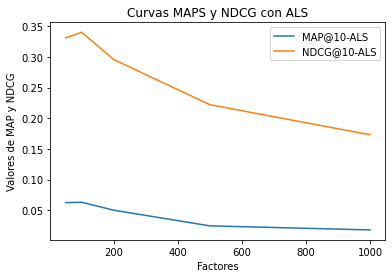

In [25]:
fact = [50,100,200,500,1000]
pares = result[1::2]
impares = result[::2]

sns.lineplot(x = fact , y = impares, label = "MAP@10-ALS")
sns.lineplot(x = fact , y = pares, label = "NDCG@10-ALS")
plt.title("Curvas MAPS y NDCG con ALS")
plt.xlabel("Factores")
plt.ylabel("Valores de MAP y NDCG")

## BPR

**Pregunta 3:** Explique con sus palabras la intuición del framework BPR.

**Respuesta:** En este algoritmo se generan tripletas de usuario, item positivo e item negativo, donde item positivo es el cual el usuario interactua y por el contrario, el item negativo es con el cual el usuario no interactua. Con esto se busca encontrar la mejor recomendación mediante diferentes metodos, como por ejemplo factorizacion matricial.

In [26]:
# Definimos y entrenamos el modelo de implicit feedback utilizando optimizacion BPR
model_bpr = implicit.bpr.BayesianPersonalizedRanking(factors=400, iterations=40, use_gpu=False)
model_bpr.fit(matrix)

  0%|          | 0/40 [00:00<?, ?it/s]

Ejemplo de recomendación y búsqueda de items similares con los factores latentes ya entrenados:

In [27]:
show_recommendations(model_bpr, user=77, n=10)

movieid
257              Men in Black (1997)
285            Secrets & Lies (1996)
746               Real Genius (1985)
299                   Hoodlum (1997)
327                  Cop Land (1997)
244    Smilla's Sense of Snow (1997)
332            Kiss the Girls (1997)
331                 Edge, The (1997)
321                    Mother (1996)
301                  In & Out (1997)
Name: title, dtype: object

In [28]:
show_similar_movies(model_bpr, item=171, n=10)

movieid
171                Delicatessen (1991)
209          This Is Spinal Tap (1984)
203                  Unforgiven (1992)
78                   Free Willy (1993)
95                      Aladdin (1992)
21       Muppet Treasure Island (1996)
27                     Bad Boys (1995)
172    Empire Strikes Back, The (1980)
194                  Sting, The (1973)
201                Evil Dead II (1987)
Name: title, dtype: object

In [29]:
maprec, ndcg = evaluate_model(model_bpr, n=10)
print('map: {}\nndcg: {}'.format(maprec, ndcg))

map: 0.05236422844388181
ndcg: 0.35987748851454826


**Pregunta 4:** Pruebe distintos valores para los parámetros de BPR y muestre gráficos de cómo se ven afectadas las métricas de ranking (nDCG@10 y MAP) recién mostradas.

In [30]:
# Definimos y entrenamos el modelo de implicit feedback utilizando optimizacion BPR @10
factores = [50,100,200,500,1000]
result = []
at = 10
for i in factores:
  model_bpr = implicit.bpr.BayesianPersonalizedRanking(factors=i, iterations=10, use_gpu=False)
  model_bpr.fit(matrix)
  maprec, ndcg = evaluate_model(model_bpr, n=at)
  print('Factores latentes:{}'.format(i))
  print('map{}: {}\nndcg@{}: {}'.format(at, maprec, at, ndcg))
  print("-------------------------")
  result.append(maprec)
  result.append(ndcg)

  0%|          | 0/10 [00:00<?, ?it/s]

Factores latentes:50
map10: 0.036766250148138474
ndcg@10: 0.28483920367534454
-------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

Factores latentes:100
map10: 0.04705032243854253
ndcg@10: 0.2986217457886677
-------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

Factores latentes:200
map10: 0.04717003762111953
ndcg@10: 0.33843797856049007
-------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

Factores latentes:500
map10: 0.04945596605119078
ndcg@10: 0.31546707503828486
-------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

Factores latentes:1000
map10: 0.051305331317184656
ndcg@10: 0.3537519142419602
-------------------------


Text(0, 0.5, 'Valores de MAP y NDCG')

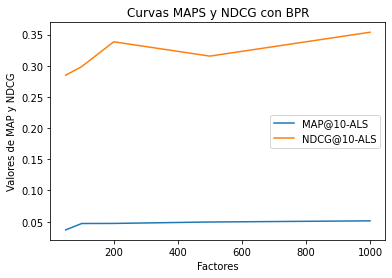

In [31]:
fact = [50,100,200,500,1000]
pares = result[1::2]
impares = result[::2]

sns.lineplot(x = fact , y = impares, label = "MAP@10-ALS")
sns.lineplot(x = fact , y = pares, label = "NDCG@10-ALS")
plt.title("Curvas MAPS y NDCG con BPR")
plt.xlabel("Factores")
plt.ylabel("Valores de MAP y NDCG")